In [1]:
import numpy as np
import matplotlib as plt
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

In [2]:
# Camers Model
class CameraModel:
    def __init__(self, w=640, h=480):
        self.w = w
        self.h = h
        self.mat  = np.eye(3, 3)  # camera matrix
        self.dist = np.zeros(6)   # distortion
        self.r    = np.eye(3, 3)  # rotation
        self.t    = np.zeros((3, 1)) # translation 
        self.mat[0][0] = w/2
        self.mat[1][1] = w/2
        self.mat[0][2] = w/2
        self.mat[1][2] = h/2
        self.r[0][0] = 1
        self.r[1][1] = -1
        self.r[2][2] = -1
        self.t[2][0] = 200
    
    def CalibrateCamera(self, objpt_list, imgpt_list, flags=0):
        rvec = cv2.Rodrigues(self.r)[0]
        ret = cv2.calibrateCamera([objpt_list.astype(np.float32)], [imgpt_list.astype(np.float32)], (self.w, self.h), self.mat, self.dist, [rvec], self.t, flags)
        self.mat  = ret[1]
        self.dist = ret[2]
        self.r    = cv2.Rodrigues(ret[3][0])[0]
        self.t    = ret[4][0]
        return ret[0]
    
    # 投影行列を作成
    def GetProjectionMatrix(self):
        return np.dot(self.mat, np.hstack((self.r, self.t)))
    
    # 物体座標を画像座標に変換
    def ObjToImg(self, objpt):
        prjmat = self.GetProjectionMatrix()
        objpt = np.append(np.array(objpt), 1).reshape(4, 1)
        imgpt = np.dot(prjmat, objpt)
        return np.array([imgpt[0][0]/imgpt[2][0], imgpt[1][0]/imgpt[2][0]])
    
    # 再投影誤差(X-Yそれぞれの二乗誤差)計算
    def CalcReprojectionError(self, objpt_list, imgpt_list):
        err = np.zeros(2)
        n = 0
        for i, objpt in enumerate(objpt_list):
            imgpt = self.ObjToImg(objpt)
            err += (imgpt - imgpt_list[i])**2
            n += 1
        return err / n

In [3]:
# モデル作成
cm = CameraModel()

In [4]:
# 調整点の物体座標を作成
objpt_list = np.ndarray((0, 3))
for z in range(-10, +20, 10):
    for y in range(-100, +100+50, 50):
        for x in range(-150, +150+50, 50):
            objpt_list = np.vstack((objpt_list, [x, y, z]))

# 撮影される画像座標を作成
imgpt_list = np.ndarray((0, 2))
for objpt in objpt_list:
    imgpt_list = np.vstack((imgpt_list, cm.ObjToImg(objpt)))
    
# 真値としてコピーを保存
true_imgpt_list = imgpt_list.copy()

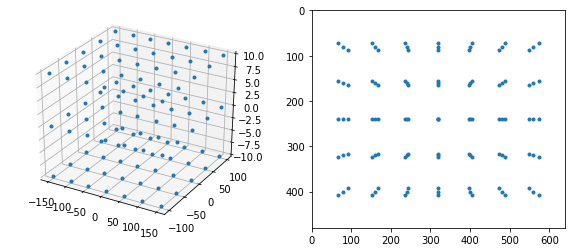

In [5]:
fig = plt.figure(figsize=(10, 4))

# 物体座標を表示
axObj = fig.add_subplot(121, projection='3d')
axObj.plot(objpt_list[:,0], objpt_list[:,1], objpt_list[:,2], '.')

# 画像座標を表示
axImg = fig.add_subplot(122)
axImg.plot(imgpt_list[:,0], imgpt_list[:,1], '.')
axImg.set_xlim(0, cm.w)
axImg.set_ylim(cm.h, 0)

plt.show()

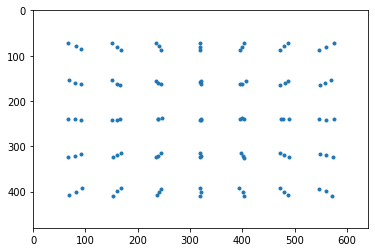

In [6]:
# ランダムに揺らぎを加える
imgpt_list = true_imgpt_list + np.random.normal(0, 1.0, true_imgpt_list.shape)

# 表示
fig = plt.figure()
plt.xlim(0, cm.w)
plt.ylim(cm.h, 0)
plt.plot(imgpt_list[:,0], imgpt_list[:,1], '.')
plt.show()

In [7]:
# calibration
retval = cm.CalibrateCamera(objpt_list, imgpt_list, cv2.CALIB_USE_INTRINSIC_GUESS)
print('retval =', retval)
print('mat =\n', cm.mat)
print('dist =\n', cm.dist)
print('r =\n', cm.r)
print('t =\n', cm.t)

retval = 1.3618412707423222
mat =
 [[315.98733938   0.         320.53935053]
 [  0.         316.68493334 238.13619202]
 [  0.           0.           1.        ]]
dist =
 [[ 0.00010394]
 [ 0.0014362 ]
 [ 0.00103982]
 [ 0.00197742]
 [-0.00320805]]
r =
 [[ 9.99983527e-01 -1.61997384e-04  5.73762358e-03]
 [-1.86786864e-04 -9.99990650e-01  4.32024104e-03]
 [ 5.73687007e-03 -4.32124158e-03 -9.99974207e-01]]
t =
 [[ -0.40368166]
 [  1.2009151 ]
 [197.67665717]]


In [8]:
# 再投影誤差
cm.CalcReprojectionError(objpt_list, imgpt_list)

array([1.50333423, 0.99361468])